In [1]:
import time
import numpy as np
import sys
import random
import pandas as pd
import os
import json
from tqdm import tqdm

# Move Class
class Move:
    def __init__(self, name, power, accuracy, type_id):
        self.name = name
        self.power = power
        self.accuracy = accuracy
        self.type_name = type_id

# Pokemon Class
class Pokemon:
    def __init__(self, name, type_ids, moves, stats):
        self.name = name
        self.type_names = type_ids
        self.moves = moves
        self.attack = stats['attack']
        self.defense = stats['defense']
        self.speed = stats['speed']
        self.hp = stats['hp']
        self.level = 50
        self.max_hp = self.hp
        self.bars = self.max_hp / 5
        self.health = '=' * 20

    def get_effectiveness(self, move, opponent):
        if not hasattr(Pokemon, 'chart_df'):
            Pokemon.chart_df = pd.read_csv("D:/adc/chart.csv").set_index("Attacking")

        attacker = str(move.type_name).capitalize()
        eff = 1.0
        for defender in opponent.type_names:
            defender_col = str(defender).capitalize()
            try:
                value = Pokemon.chart_df.loc[attacker][defender_col]
                if float(value) == 0.0:
                    return 0.0
                eff *= float(value)
            except KeyError:
                eff *= 1.0
        return eff

    def use_move(self, move, opponent):
        if random.randint(1, 100) > move.accuracy:
            return
        stab = 1.5 if move.type_name in self.type_names else 1.0
        effectiveness = self.get_effectiveness(move, opponent)
        crit = 2.0 if random.random() < 0.1 else 1.0
        modifier = stab * effectiveness * crit * random.uniform(0.85, 1.0)
        base_damage = (((2 * self.level / 5 + 2) * move.power * self.attack / opponent.defense) / 50 + 2) * modifier
        opponent.bars -= base_damage / 5
        opponent.bars = max(opponent.bars, 0)
        opponent.health = '=' * max(1, int(opponent.bars))


def get_pokemon(name):
    poke = next((p for p in pokemon_data if p['name'].lower() == name.lower()), None)
    stats = {'attack': poke['attack'], 'defense': poke['defense'], 'speed': poke['speed'], 'hp': poke['hp']}
    moves = []
    for i in range(1, 5):
        if f"move_{i}_name" in poke and not pd.isna(poke[f"move_{i}_name"]):
            moves.append(Move(
                poke[f"move_{i}_name"],
                poke[f"move_{i}_power"],
                poke[f"move_{i}_accuracy"],
                poke[f"move_{i}_type"]
            ))
    types = [poke['type_1']]
    if 'type_2' in poke and isinstance(poke['type_2'], str) and poke['type_2'].lower() != 'nan':
        types.append(poke['type_2'])
    return Pokemon(poke['name'].capitalize(), types, moves, stats)


def simulate_battle(team1, team2):
    rounds = []
    total_damage = {'team1': 0, 'team2': 0}
    damage_record = {'team1': {}, 'team2': {}}
    total_turns = 0
    i, j = 0, 0

    while i < 6 and j < 6:
        p1 = team1[i]
        p2 = team2[j]
        p1.bars = p1.max_hp / 5
        p2.bars = p2.max_hp / 5
        p1.health = '=' * 20
        p2.health = '=' * 20
        turns = 0

        while p1.bars > 0 and p2.bars > 0:
            attacker, defender = (p1, p2) if p1.speed >= p2.speed else (p2, p1)
            for atk, dfn in [(attacker, defender), (defender, attacker)]:
                if dfn.bars <= 0:
                    break
                move = random.choice(atk.moves)
                old_bar = dfn.bars
                atk.use_move(move, dfn)
                dmg = max(0, (old_bar - dfn.bars) * 5)
                team_key = 'team1' if atk == p1 else 'team2'
                total_damage[team_key] += dmg
                damage_record[team_key][atk.name] = damage_record[team_key].get(atk.name, 0) + dmg
                if dfn.bars <= 0:
                    break
            turns += 1

        rounds.append({
            "p1": p1.name,
            "p2": p2.name,
            "winner": "p1" if p2.bars <= 0 else "p2",
            "turns": turns,
            "p1_damage": round(p1.max_hp - p1.bars * 5, 2),
            "p2_damage": round(p2.max_hp - p2.bars * 5, 2)
        })

        if p2.bars <= 0:
            j += 1
        else:
            i += 1
        total_turns += turns

    winner = 'team1' if j == 6 else 'team2'

    return {
        "team1": [p.name for p in team1],
        "team2": [p.name for p in team2],
        "team1_types": [p.type_names for p in team1],
        "team2_types": [p.type_names for p in team2],
        "team1_stats": [{
            "hp": p.hp,
            "atk": p.attack,
            "def": p.defense,
            "spd": p.speed,
            "type": p.type_names,
            "moves": [m.type_name for m in p.moves]
        } for p in team1],
        "team2_stats": [{
            "hp": p.hp,
            "atk": p.attack,
            "def": p.defense,
            "spd": p.speed,
            "type": p.type_names,
            "moves": [m.type_name for m in p.moves]
        } for p in team2],
        "winner": winner,
        "rounds": rounds,
        "total_turns": total_turns,
        "total_damage": total_damage
    }

if __name__ == '__main__':
    pokemon_data = np.load("D:/adc/pokemon_master_dataset_fixed.npy", allow_pickle=True)
    clean_pokemon = [p for p in pokemon_data if not pd.isna(p['move_4_name'])]
    names = [p['name'] for p in clean_pokemon]

    with open("D:/adc/battle_log.json", "w") as log_file:
        for _ in tqdm(range(100000), desc="Simulating Battles"):
            selected = random.sample(names, 12)
            team1 = [get_pokemon(name) for name in selected[:6]]
            team2 = [get_pokemon(name) for name in selected[6:]]
            result = simulate_battle(team1, team2)
            log_file.write(json.dumps(result) + "\n")




Simulating Battles: 100%|█████████████████████████████████████████████████████| 100000/100000 [03:35<00:00, 464.19it/s]


In [2]:
import pandas as pd
import json
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# --- Step 1: Load JSON Lines ---
data = []
with open("D:/adc/battle_log.json", "r") as f:
    for line in f:
        data.append(json.loads(line))

# --- Step 2: Parse into Features ---
rows = []
for d in data:
    row = {
        'winner': 1 if d['winner'] == 'team1' else 0,
        'team1_total_damage': d['total_damage']['team1'],
        'team2_total_damage': d['total_damage']['team2'],
        'total_turns': d['total_turns']
    }
    for stat in ['hp', 'atk', 'def', 'spd']:
        row[f'team1_avg_{stat}'] = sum(p[stat] for p in d['team1_stats']) / 6
        row[f'team2_avg_{stat}'] = sum(p[stat] for p in d['team2_stats']) / 6
    rows.append(row)

df = pd.DataFrame(rows)

# --- Step 3: Define X and y ---
X = df.drop(columns=["winner"])  # All features
y = df["winner"]                 # Label

# --- Step 4: Split and Train ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=1.0,
    
    eval_metric='logloss'
)

model.fit(X_train, y_train)

# --- Step 5: Evaluate ---
y_pred = model.predict(X_test)
print("✅ Accuracy:", accuracy_score(y_test, y_pred))

# --- Optional: Save model ---
import joblib
joblib.dump(model, "D:/adc/pokemon_battle_predictor_xgb.pkl")
print("✅ Model saved as 'pokemon_battle_predictor_xgb.pkl'")


✅ Accuracy: 0.93955
✅ Model saved as 'pokemon_battle_predictor_xgb.pkl'


In [3]:
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Train Accuracy: 0.9470
Test Accuracy: 0.9395


In [4]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5)
print(f"Cross-Validation: {scores.mean():.4f} ± {scores.std():.4f}")


Cross-Validation: 0.9405 ± 0.0015


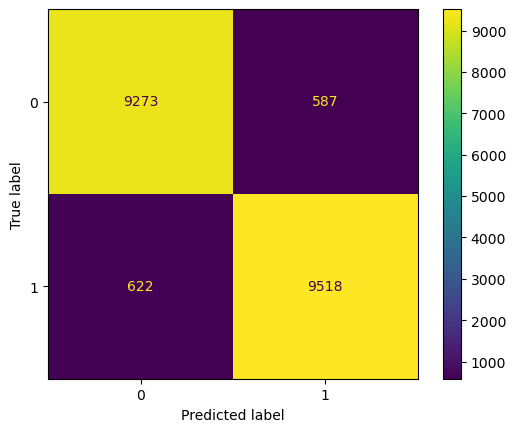

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()


Select AI Difficulty Level (1 to 10):


Enter level (1 = Easy, 10 = Hard):  5



🔁 AI Difficulty set to Level 5 → 50000 candidate teams

👤 Your Team:
- Meowscarada
- Scizor
- Skwovet
- Garbodor
- Minior-indigo
- Scovillain

🤖 AI Team:
- Igglybuff
- Magnezone
- Roggenrola
- Copperajah
- Ferroseed
- Nidoran-m

🧠 ML Prediction: AI has a 90.44% win chance

Your Team:
1. Meowscarada
2. Scizor
3. Skwovet
4. Garbodor
5. Minior-indigo
6. Scovillain


Choose your Pokémon:  1



-----POKEMON BATTLE-----
Meowscarada vs Igglybuff


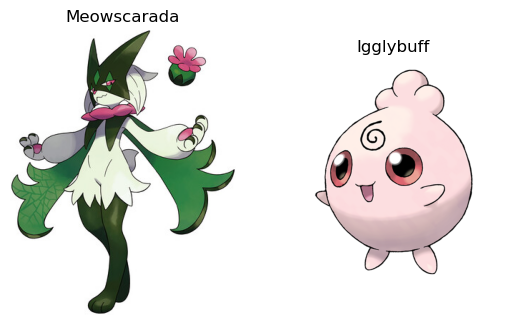

Meowscarada: ==================== | HP: 76/76
Igglybuff: ==================== | HP: 90/90

Go Meowscarada!
1. thunder-punch (Power: 75.0, Acc: 100.0)
2. scratch (Power: 40.0, Acc: 100.0)
3. take-down (Power: 90.0, Acc: 85.0)
4. bite (Power: 60.0, Acc: 100.0)


Pick a move:  1



Meowscarada used thunder-punch!
--> It dealt 228.28 damage!
...Igglybuff fainted!
Your Team:
1. Meowscarada
2. Scizor
3. Skwovet
4. Garbodor
5. Minior-indigo
6. Scovillain


Choose your Pokémon:  1



-----POKEMON BATTLE-----
Meowscarada vs Magnezone


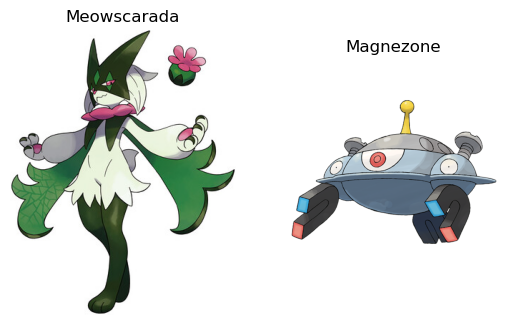

Meowscarada: ==================== | HP: 76/76
Magnezone: ==================== | HP: 70/70

Go Meowscarada!
1. thunder-punch (Power: 75.0, Acc: 100.0)
2. scratch (Power: 40.0, Acc: 100.0)
3. take-down (Power: 90.0, Acc: 85.0)
4. bite (Power: 60.0, Acc: 100.0)


Pick a move:  2



Meowscarada used scratch!
--> It dealt 18.7 damage!
Go Magnezone!
1. tackle (Power: 40.0, Acc: 100.0)
2. body-slam (Power: 85.0, Acc: 100.0)
3. take-down (Power: 90.0, Acc: 85.0)
4. double-edge (Power: 120.0, Acc: 100.0)

Magnezone used double-edge!
--> It dealt 52.43 damage!Meowscarada: ==== | HP: 23/76
Magnezone: ========== | HP: 51/70

Go Meowscarada!
1. thunder-punch (Power: 75.0, Acc: 100.0)
2. scratch (Power: 40.0, Acc: 100.0)
3. take-down (Power: 90.0, Acc: 85.0)
4. bite (Power: 60.0, Acc: 100.0)


Pick a move:  1



Meowscarada used thunder-punch!
--> It dealt 29.75 damage!
Go Magnezone!
1. tackle (Power: 40.0, Acc: 100.0)
2. body-slam (Power: 85.0, Acc: 100.0)
3. take-down (Power: 90.0, Acc: 85.0)
4. double-edge (Power: 120.0, Acc: 100.0)

Magnezone used double-edge!
--> It dealt 53.13 damage!
...Meowscarada fainted!
Your Team:
1. Scizor
2. Skwovet
3. Garbodor
4. Minior-indigo
5. Scovillain


In [ ]:
# import time
import numpy as np
import sys
import random
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import joblib
import json

# Load ML model and dataset
model = joblib.load("D:/adc/pokemon_battle_predictor_xgb.pkl")
pokemon_data = np.load("D:/adc/pokemon_master_dataset_fixed.npy", allow_pickle=True)
all_names = [p['name'] for p in pokemon_data]

# ELO Scores (in-memory for now)
ai_elo = 1000
user_elo = 1000

# Show image
def show_pokemon_image(name, title=None, subplot_index=None):
    try:
        img_path = f"D:/idm downloads/Pokemon Dataset/{name.lower()}.png"
        if not os.path.exists(img_path):
            import requests
            response = requests.get(f"https://img.pokemondb.net/artwork/{name.lower()}.jpg")
            if response.status_code == 200:
                with open(img_path, 'wb') as f:
                    f.write(response.content)
        img = Image.open(img_path)
        if subplot_index:
            plt.subplot(1, 2, subplot_index)
            plt.imshow(img)
            plt.axis('off')
            plt.title(title or name)
        else:
            plt.imshow(img)
            plt.axis('off')
            plt.title(title or name)
            plt.show()
    except:
        print(f"[Image not found for {name}]")

# Delay print
def delay_print(s):
    for c in s:
        sys.stdout.write(c)
        sys.stdout.flush()
        time.sleep(0.02)

# Move class
class Move:
    def __init__(self, name, power, accuracy, type_id):
        self.name = name
        self.power = power
        self.accuracy = accuracy
        self.type_name = type_id

# Pokemon class
class Pokemon:
    def __init__(self, name, type_ids, moves, stats, is_ai=False):
        self.name = name
        self.type_names = type_ids
        self.moves = moves
        self.attack = stats['attack']
        self.defense = stats['defense']
        self.speed = stats['speed']
        self.hp = stats['hp']
        self.level = 50
        self.max_hp = self.hp
        self.bars = self.max_hp / 5
        self.health = '=' * 20
        self.is_ai = is_ai

    def get_effectiveness(self, move, opponent):
        if not hasattr(Pokemon, 'chart_df'):
            Pokemon.chart_df = pd.read_csv("D:/adc/chart.csv").set_index("Attacking")
        eff = 1.0
        for defender in opponent.type_names:
            try:
                eff *= float(Pokemon.chart_df.loc[move.type_name.capitalize()][defender.capitalize()])
            except:
                eff *= 1.0
        return eff

    def use_move(self, move, opponent):
        if random.randint(1, 100) > move.accuracy:
            delay_print(f"\n{self.name}'s {move.name} missed!")
            return
        stab = 1.5 if move.type_name in self.type_names else 1.0
        effectiveness = self.get_effectiveness(move, opponent)
        crit = 2.0 if random.random() < 0.1 else 1.0
        modifier = stab * effectiveness * crit * random.uniform(0.85, 1.0)
        base_damage = (((2 * self.level / 5 + 2) * move.power * self.attack / opponent.defense) / 50 + 2) * modifier
        opponent.bars -= base_damage / 5
        opponent.bars = max(opponent.bars, 0)
        opponent.health = '=' * max(1, int(opponent.bars))
        delay_print(f"\n{self.name} used {move.name}!")
        if effectiveness > 1: delay_print("\nIt's super effective!")
        elif effectiveness < 1: delay_print("\nIt's not very effective...")
        if crit > 1: delay_print("\nA critical hit!")
        delay_print(f"\n--> It dealt {round(base_damage, 2)} damage!")

    def fight(self, other):
        delay_print(f"\n-----POKEMON BATTLE-----\n{self.name} vs {other.name}\n")
        show_pokemon_image(self.name, title=self.name, subplot_index=1)
        show_pokemon_image(other.name, title=other.name, subplot_index=2)
        plt.show()
        while self.bars > 0 and other.bars > 0:
            print(f"{self.name}: {self.health} | HP: {int(self.bars*5)}/{self.max_hp}")
            print(f"{other.name}: {other.health} | HP: {int(other.bars*5)}/{other.max_hp}")
            first, second = (self, other) if self.speed >= other.speed else (other, self)
            for attacker, defender in [(first, second), (second, first)]:
                if defender.bars <= 0:
                    break
                print(f"\nGo {attacker.name}!")
                for i, move in enumerate(attacker.moves):
                    print(f"{i+1}. {move.name} (Power: {move.power}, Acc: {move.accuracy})")
                if attacker.is_ai:
                    idx = max(
                        range(len(attacker.moves)),
                        key=lambda i: attacker.moves[i].power *
                                      (1.5 if attacker.moves[i].type_name in attacker.type_names else 1.0) *
                                      attacker.get_effectiveness(attacker.moves[i], defender) *
                                      (attacker.moves[i].accuracy / 100)
                    )
                else:
                    try:
                        idx = int(input("Pick a move: ")) - 1
                        if not 0 <= idx < len(attacker.moves):
                            raise ValueError
                    except:
                        print("Invalid move selection. Skipping turn.")
                        continue
                attacker.use_move(attacker.moves[idx], defender)
                if defender.bars <= 0:
                    delay_print(f"\n...{defender.name} fainted!")
                    break
        return self.bars > 0

def extract_team_features(team):
    stats = {'attack': [], 'defense': [], 'speed': [], 'hp': [], 'move_power': [], 'move_accuracy': []}
    for p in team:
        stats['attack'].append(p['attack'])
        stats['defense'].append(p['defense'])
        stats['speed'].append(p['speed'])
        stats['hp'].append(p['hp'])
        for i in range(1, 5):
            if f"move_{i}_power" in p and not np.isnan(p[f"move_{i}_power"]):
                stats['move_power'].append(p[f"move_{i}_power"])
            if f"move_{i}_accuracy" in p and not np.isnan(p[f"move_{i}_accuracy"]):
                stats['move_accuracy'].append(p[f"move_{i}_accuracy"])
    return [
        np.mean(stats['attack']), np.std(stats['attack']),
        np.mean(stats['defense']), np.std(stats['defense']),
        np.mean(stats['speed']), np.std(stats['speed']),
        np.mean(stats['hp']), np.std(stats['hp']),
        np.mean(stats['move_power']) if stats['move_power'] else 0,
        np.mean(stats['move_accuracy']) if stats['move_accuracy'] else 0,
        len(team)
    ]

def get_pokemon(name, is_ai=False):
    poke = next((p for p in pokemon_data if p['name'].lower() == name.lower()), None)
    stats = {k: poke[k] for k in ['attack', 'defense', 'speed', 'hp']}
    moves = [
        Move(poke[f"move_{i}_name"], poke[f"move_{i}_power"], poke[f"move_{i}_accuracy"], poke[f"move_{i}_type"])
        for i in range(1, 5)
        if f"move_{i}_name" in poke and not pd.isna(poke[f"move_{i}_name"])
    ]
    types = [poke['type_1']] + ([poke['type_2']] if 'type_2' in poke and isinstance(poke['type_2'], str) else [])
    return Pokemon(poke['name'].capitalize(), types, moves, stats, is_ai=is_ai)

def update_elo(rating_a, rating_b, result_a, k=32):
    expected_a = 1 / (1 + 10 ** ((rating_b - rating_a) / 400))
    return rating_a + k * (result_a - expected_a)

def get_best_switch(ai_team, user_poke):
    best_poke = None
    best_eff = 0
    for poke in ai_team:
        if poke.bars <= 0: continue
        avg_eff = np.mean([poke.get_effectiveness(m, user_poke) for m in poke.moves])
        if avg_eff > best_eff:
            best_eff = avg_eff
            best_poke = poke
    return best_poke

# Prompt user to select AI difficulty level
print("Select AI Difficulty Level (1 to 10):")
try:
    difficulty_input = int(input("Enter level (1 = Easy, 10 = Hard): "))
    difficulty_input = max(1, min(10, difficulty_input))
except:
    difficulty_input = 1

level = difficulty_input * 10000
print(f"\n🔁 AI Difficulty set to Level {difficulty_input} → {level} candidate teams")

# Battle setup
user_team_data = random.sample(list(pokemon_data), 6)
user_features = extract_team_features(user_team_data)

candidates = [random.sample(list(pokemon_data), 6) for _ in range(level)]
ai_features_list = [extract_team_features(team) for team in candidates]
vectors = [np.array(user_features) - np.array(ai_feat) for ai_feat in ai_features_list]
probs = model.predict_proba(vectors)[:, 1]
ai_win_probs = 1 - probs
best_idx = np.argmax(ai_win_probs)
best_prob = ai_win_probs[best_idx]
best_team = candidates[best_idx]

ai_team = [get_pokemon(p['name'], is_ai=True) for p in best_team]
user_team = [get_pokemon(p['name']) for p in user_team_data]

print("\n👤 Your Team:")
for p in user_team: print(f"- {p.name}")
print("\n🤖 AI Team:")
for p in ai_team: print(f"- {p.name}")
print(f"\n🧠 ML Prediction: AI has a {round(best_prob * 100, 2)}% win chance")

# Battle
while user_team and ai_team:
    print("\nYour Team:")
    for i, poke in enumerate(user_team):
        print(f"{i+1}. {poke.name}")
    try:
        choice = int(input("Choose your Pokémon: ")) - 1
        if not 0 <= choice < len(user_team): raise ValueError
    except:
        print("Invalid input.")
        continue

    user_poke = user_team[choice]
    ai_poke = get_best_switch(ai_team, user_poke)
    if not ai_poke: break

    user_won = user_poke.fight(ai_poke)

    if ai_poke.bars <= 0: ai_team.remove(ai_poke)
    if user_poke.bars <= 0: user_team.pop(choice)

winner = "User" if user_team else "AI"
print(f"\n🏁 Battle Over! Winner: {winner}")

result_user = 1 if winner == "User" else 0
user_elo = update_elo(user_elo, ai_elo, result_user)
ai_elo = update_elo(ai_elo, user_elo, 1 - result_user)

print(f"\n📈 Updated ELO Ratings → User: {round(user_elo)} | AI: {round(ai_elo)}")

if winner == "AI":
    print("\n💀 You lost. Try again at lower difficulty.")
else:
    print("\n✅ You won! Great job!")
